## In this notebook we train a neural network to model the data using Pytorch

In [1]:
import torch
from torch import nn
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
bike = pd.read_csv('bike_features_final.csv')

/tmp/ipykernel_80/1740552796.py:1: DtypeWarning: Columns (6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  bike = pd.read_csv('bike_features_final.csv')


In [3]:
#Independent variables used
variables= ["member_casual","weekend_weekday","ride_length_seconds","with_friend","ride_type","time_of_day","speed_kmh"]
bike_vars = bike[variables]

In [4]:
#test,train split (30%/70%)
y = bike.Dist
X, x_test, y_train, y_test = train_test_split(bike_vars, y, test_size=0.3,random_state=1)
X=pd.get_dummies(X, drop_first=True)
x_test=pd.get_dummies(x_test, drop_first=True)

In [5]:
X = StandardScaler().fit_transform(X)
x_test = StandardScaler().fit_transform(x_test)

In [6]:
#create tensors the pytorch can use
X = torch.from_numpy(X)
x_test = torch.from_numpy(x_test)
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

In [7]:
training_set = torch.utils.data.TensorDataset(X,y_train)

In [8]:
validation_set  = torch.utils.data.TensorDataset(x_test,y_test)

In [9]:
trainloader =  torch.utils.data.DataLoader(training_set, batch_size=200, shuffle=True)

In [15]:
## number of training batches
len(trainloader)

9058

In [16]:
validationloader = torch.utils.data.DataLoader(validation_set, batch_size=200, shuffle=True)

In [17]:
iter(trainloader).next()

[tensor([[ 1.0691, -0.3535, -0.1691,  ..., -0.6239, -0.5396,  1.2232],
         [ 1.0691, -1.0357, -0.1691,  ...,  1.6028, -0.5396, -0.8176],
         [ 1.0691, -0.8043, -0.1691,  ...,  1.6028, -0.5396, -0.8176],
         ...,
         [-0.9353, -0.8009, -0.1691,  ...,  1.6028, -0.5396, -0.8176],
         [-0.9353, -0.5849, -0.1691,  ..., -0.6239, -0.5396,  1.2232],
         [ 1.0691,  3.2424, -0.1691,  ..., -0.6239, -0.5396, -0.8176]],
        dtype=torch.float64),
 tensor([ 1.1746,  0.6632,  1.1866,  5.0378,  0.9158,  4.5241,  2.3926,  3.4876,
          1.8614,  0.7558,  2.9032,  0.7955,  9.2930,  0.9513,  0.4642,  2.3572,
          2.1342,  1.7614,  1.6679,  6.5263,  6.3346,  3.0006,  7.2708,  7.3078,
          1.2644,  3.4100,  4.1086,  1.1840,  2.8505,  1.8790,  4.7496,  1.3293,
          1.8654,  5.6073,  0.5389,  0.7470,  0.6777,  2.6076,  1.4923,  1.0082,
          3.2082,  4.1170,  1.1517,  2.4923,  5.0910,  2.6162,  9.0361,  1.0143,
          1.5020,  4.0421,  3.1734,  2.0205

In [18]:
train_data, train_labels = iter(trainloader).next()

In [19]:
## number of input layers
train_data[2].shape

torch.Size([9])

In [20]:
validation_data, validation_labels = iter(validationloader).next()

### We will train a simple neural network with 2 layers and ReLu activation function

In [21]:
class RegressionNN(nn.Module):
    '''
      multilayer network for regression
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Linear(9, 64),
          nn.ReLU(),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Linear(32, 1)
        )


    def forward(self, x):
        '''
          Forward pass
        '''
        return self.layers(x)

In [22]:
#Loss functions and optimizer
model=RegressionNN()

loss_function = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [26]:
## GPU used by Amazon SageMaker Studio Lab
torch.cuda.get_device_name(0)

'Tesla T4'

In [28]:
#initiate lists to hold evaluation and train losses
eval_losses=[] 
train_losses = []

In [29]:
# Define the training loop so we can store the values
def train(epoch): 
    model.train()
    # Print epoch
    print('\nEpoch : %d'%epoch)
    
    # zero out current loss value
    running_loss = 0.0
    
    # Iterate over the DataLoader for training data
    for features,dist in trainloader:
      
      # Get and prepare inputs
        inputs = features
        targets = dist.view((dist.shape[0], -1))
        inputs, targets = inputs.float(), targets.float()
      
      # Zero the gradients
        optimizer.zero_grad()
      
      # Perform forward pass
        outputs = model(inputs)
      
      # Compute loss
        loss = loss_function(outputs, targets)
      
      # Perform backward pass
        loss.backward()
      
      # Perform optimization
        optimizer.step()
      
      # Print statistics
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
        train_losses.append(running_loss/len(trainloader))

In [30]:
#Function to use the current epoch to model the evaluation data
def test(epoch):
    model.eval()
 
    running_loss=0
    with torch.no_grad():
        for features,dist in validationloader:
            inputs = features
            targets = dist.view((dist.shape[0], -1))
            inputs, targets = inputs.float(), targets.float()
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = loss_function(outputs, targets)
            
            running_loss += loss.item()
        else:
            print(f"Validation loss: {running_loss/len(trainloader)}")
            eval_losses.append(running_loss/len(trainloader))

In [32]:
eval_losses=[] 
train_losses = []
epochs=50
# Early stopping
last_loss = 100
patience = 5
triggertimes = 0
for epoch in range(1,epochs+1): 
    train(epoch)
    test(epoch)
    if eval_losses[-1] > last_loss:
        last_loss = eval_losses[-1]
        trigger_times += 1
        print('Trigger Times:', trigger_times)
        if trigger_times >= patience:
            print('Early stopping!')
            break
        else: 
            continue
        break
    else:
        print('Trigger times: 0')
        trigger_times = 0
        last_loss = eval_losses[-1]
        continue
    break


Epoch : 1
Training loss: 0.012921179690260295
Validation loss: 0.004946940319214101
Trigger times: 0

Epoch : 2
Training loss: 0.01021910072434887
Validation loss: 0.004796398591273212
Trigger times: 0

Epoch : 3
Training loss: 0.009423995839847677
Validation loss: 0.0036301469113854587
Trigger times: 0

Epoch : 4
Training loss: 0.008809231593258979
Validation loss: 0.0038494977155269726
Trigger Times: 1

Epoch : 5
Training loss: 0.008519265385690915
Validation loss: 0.0051026578295912586
Trigger Times: 2

Epoch : 6
Training loss: 0.008225228753897921
Validation loss: 0.002869382524862063
Trigger times: 0

Epoch : 7
Training loss: 0.007994862674581465
Validation loss: 0.0027724287464337078
Trigger times: 0

Epoch : 8
Training loss: 0.007798796991261821
Validation loss: 0.0034203776243217016
Trigger Times: 1

Epoch : 9
Training loss: 0.007603052170880568
Validation loss: 0.0026275566515349697
Trigger times: 0

Epoch : 10
Training loss: 0.0074407922503036475
Validation loss: 0.002798391

### The validation losses seem to jump around a lot, but stay stable around .003. After about 35 epochs we seem to achieve the minimum loss

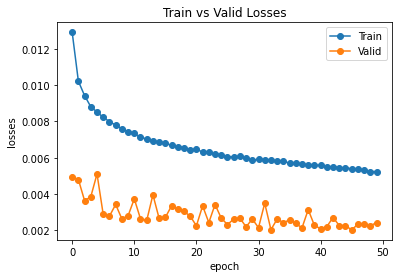

In [34]:
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
plt.show()

In [36]:
### need to reshape labels to fit proper shape (otherwise we cannot evaluate the model properply)
validation_labels = validation_labels.view((validation_labels.shape[0], -1))

In [37]:
validation_data, validation_labels = validation_data.float(), validation_labels.float()
with torch.no_grad():
    model.eval()
    y_pred = model(validation_data)

### True values vs predicted values. There doesn't seem to be a pattern in the data, all predicted values are pretty close to actual values

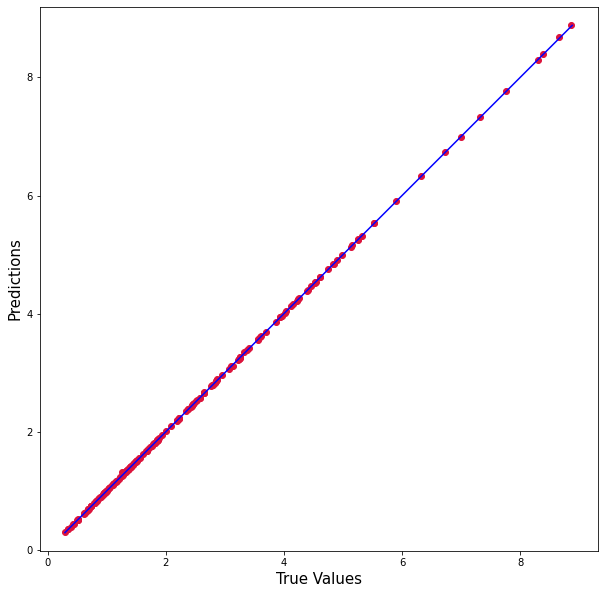

In [43]:
plt.figure(figsize=(10,10))
plt.scatter(validation_labels, y_pred, c='crimson')

p1 = max(max(y_pred), max(validation_labels))
p2 = min(min(y_pred), min(validation_labels))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [ ]:
#model deployment (heroku, streamlit)
#Github w/ readme file (comment in markdown below codeblocks, readMe file)
#ReadMe -> how do I reproduce the code
#https://www.freecodecamp.org/news/how-to-write-a-good-readme-file/